In [73]:
# Import libraries
using Turing
using DifferentialEquations
using StatsPlots
using LinearAlgebra
using Sundials
using Distributions
using Sobol
using QuasiMonteCarlo
using GlobalSensitivity
using DiffEqSensitivity
using MultivariateStats
import MultivariateStats: reconstruct
using GaussianProcesses
using ScikitLearn
using StatsBase
using Suppressor

# Set a seed for reproducibility
using Random
#Random.seed!(11);

### Uncertainty Quantification Tutorial 

In this notebook, we will implement an ODE model from the literature for a Hes1 protein transcription model that has some interesting oscillatory behavior (see (Liepe et al. 2013, PLOS Comp. Bio.) for more information). 

We will go through a typical Bayesian Workflow, from start to finish, and then an Emulation workflow. All of the methods we will use apply to any type of problem -- not limited to biology! 

We begin with the Bayesian workflow. First, we must define our model...

##### Model Specification


The system of equations we want to do parameter estimation with is as follows:

$$ \frac{dm}{dt} = -k_d m + \frac{1}{1 + (\frac{p_2}{P_0})^h} $$
$$ \frac{dp_1}{dt} = -k_d p_1 + \nu m - k_1 p_1 $$
$$ \frac{dp_2}{dt} = -k_d p_2 + k_1 p_1 $$

Where are parameters are: $\theta = [k_1, \nu, h, P_0] $ and $k_d$ is fixed. 
And our model outputs are: $y = [m, p_1, p_2]$ though we consider the total value of proteins $p_1$ + $p_2$.



In [74]:
# Define ODE model
# Implementing Hes1 transcription model from (Liepe et al. 2013, PLOS Comp. Bio.) 

function my_ode_model(du, u, p, t)
    # Define some variable names
    m = u[1]
    p1 = u[2]
    p2 = u[3]

    # Define some parameter names
    kd = 5.0e-4 # The ODE system is stiff w.r.t. this parameter and so it remains fixed
    k1 = p[1]
    ν = p[2]
    P₀ = p[3]
    h = p[4]

    du[1] = -kd * m + (1 / (1 + ((p2+1e-3)/P₀)^h))
    du[2] = -kd * p1 + ν * m - k1 * p1
    du[3] = -kd * p2 + k1 * p1
    
    return nothing
end;

To give a visual of what the model outputs look like under "nominal" conditions, we'll solve and plot the results of the initial value problem.

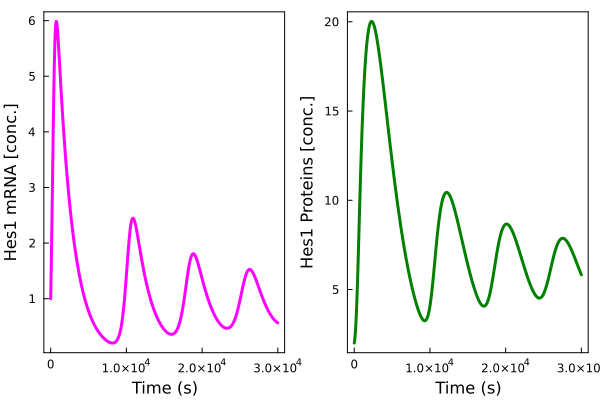

In [75]:
# Specify and solve the initial-value problem
# Define initial-value problem.
u0 = [1.0, 1.0, 1.0]
p = [1.66e-4, 3.33e-3, 0.5, 7.0] # nominal param settings known to cause oscillatory behavior
tspan = (0.0, 30_000)
prob = ODEProblem(my_ode_model, u0, tspan, p)

# Plot simulation.
nominal_res = solve(prob, Tsit5(); saveat=10.0)

# Using subplots
l = @layout [a b]

p1 = plot(nominal_res.t, nominal_res[1,:], legend=false, xlabel="Time (s)", ylabel="Hes1 mRNA [conc.]", grid=false, framestyle=:box, linewidth=3, linecolor=:magenta)
p2 = plot(nominal_res.t, nominal_res[2,:] .+ nominal_res[3,:], legend=false, xlabel="Time (s)", ylabel="Hes1 Proteins [conc.]", grid=false, framestyle=:box, linewidth=3, linecolor=:green)
plot(p1, p2, layout = l)

##### "Data Collection"

In the absence of any experimental measurements for the concentrations of Hes1 proteins and mRNA in this pathway, we will generate synthetic experimental data by adding normally distributed noise

$$\frac{dy}{dt} = F(x(t),\theta) + \epsilon,\qquad \epsilon\sim N(0,\sigma^2)$$
$$x(0) = x^0$$

In Julia, the randn() function creates a randomly distributed number with mean 0 and standard deviation 1. 

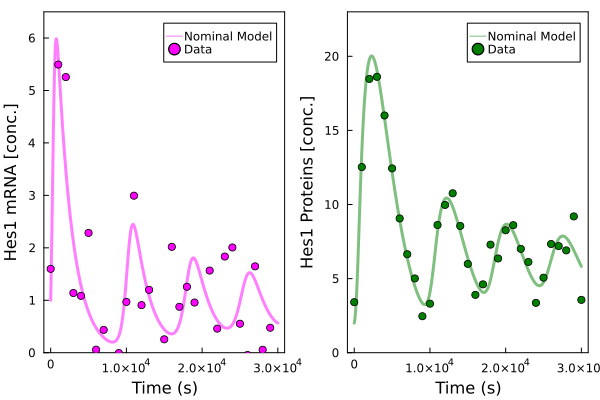

In [76]:
# Generate synthetic experimental data
# Decreasing the saveat parameter leads to fewer saved data points
data_res = solve(prob, Tsit5(); saveat=1000)
σ = 0.8
synthetic_data = Array(data_res) + σ * randn(size(Array(data_res)))

length_time_series = length(data_res.t)

# Plot simulation and noisy observations.
l = @layout [a b]

p1 = plot(nominal_res.t, nominal_res[1,:], legend=false, xlabel="Time (s)", ylabel="Hes1 mRNA [conc.]", grid=false, framestyle=:box, linewidth=3, linecolor=:magenta, alpha=0.5, label="Nominal Model")
p2 = plot(nominal_res.t, nominal_res[2,:] .+ nominal_res[3,:], legend=false, xlabel="Time (s)", ylabel="Hes1 Proteins [conc.]", grid=false, framestyle=:box, linewidth=3, linecolor=:green, alpha=0.5, label="Nominal Model")

scatter!(p1, data_res.t, synthetic_data[1,:]; color=:magenta, ylim=(0, 6.5), label="Data")
scatter!(p2, data_res.t, synthetic_data[2,:] .+ synthetic_data[3,:]; ylim=(0, 23),color=:green, label="Data")

plot(p1, p2, layout = l, legend=true)


##### Prior Specification and Prior Predictive Distribution

Because we changes the saveat parameter in the ODE solve call to a larger number, we save the solution at fewer time points to get a more reasonable quantity of "experimental" data.

Now let's look at the prior predictive distribution.

The prior predictive check generates data (model output) according to samples from the priors on each of the parameters and allows us to assess whether the priors are appropriate (do they match the data?)

We draw samples from our priors:

$$\theta^{sim} \sim p(\theta)$$

Then simulate data:

$$y^{sim} \sim  p(y|\theta^{sim})$$

Which results in a simulation from the joint distribution:

$$(y^{sim}, \theta^{sim}) \sim p(y,\theta)$$

Which will give us many $(y^{sim}, \theta^{sim})$ pairs to approximate

$$y^{sim} \sim p(y)$$

  0.905251 seconds (1.25 M allocations: 92.693 MiB, 99.93% compilation time)


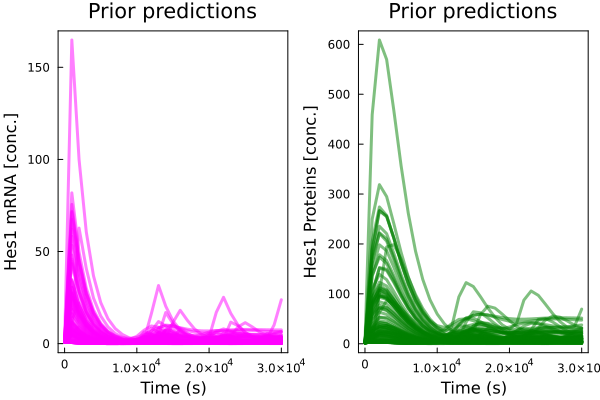

In [77]:
# Let's look at the prior predictive distribution
# We'll draw samples from our prior distributions
N_samp = 100
means = [1.66e-4, 3.33e-3, 0.5, 7.0]
stds = [0.000125, 0.000125, 0.25, 2.75]

# Make distributions
d = truncated.(Normal.(means, stds), lower=1e-8)

# Simulate using Julia's Ensemble methods from their ODE library
prob_func = (prob,i,repeat) -> remake(prob,p=rand.(d))
myproblem = EnsembleProblem(prob, prob_func = prob_func, safetycopy = false)
@time sol = solve(myproblem, Tsit5(), EnsembleThreads(), trajectories=N_samp, saveat=1000)

# Plot some trajectories
p1 = plot()
p2 = plot()
for i in 1:size(sol,3)
    plot!(p1, sol[i].t, sol[i][1,:], legend=false, xlabel="Time (s)", ylabel="Hes1 mRNA [conc.]", grid=false, framestyle=:box, linewidth=3, linecolor=:magenta, alpha=0.5)
    plot!(p2, sol[i].t, sol[i][2,:] .+ sol[i][3,:], legend=false, xlabel="Time (s)", ylabel="Hes1 Proteins [conc.]", grid=false, framestyle=:box, linewidth=3, linecolor=:green, alpha=0.5)
end

plot(p1, p2, layout = l, title = "Prior predictions")

It is clear from this prior predictive check that the priors we've selected include parameter settings that lead to different kinds of system dynamic behavior -- some oscillatory and some other dynamics as well. We know the model is stiff with respect to the rate parameters, so we choose relatively narrow priors for these parameters.

We can also zoom in around our data and see if the time series match the data...by design, since we have generated our own synthetic measurements, some of these will match. But in general, if you are working with experimental measurements and you don't see any prior samples leading to similarity in the data, there is likely an issue in the prior or likelihood specification. 

### Bayesian Inference: Probabilistic Model Specification

Next we will use Julia's Turing.jl library for defining our probability model. Turing is a probabilistic programming library, so we can define our model in a way that is intuitive to how we write it down in "math". 

Namely, our parameters are drawn from our priors, and our simulation data is drawn from a multivariate normal distribution (our likelihood function). 

In [78]:

# Do Bayesian parameter estimation for our model
@model function estimate_Hes1_params(data, prob)
    # Define the prior distributions for our parameters
    k1 ~ d[1]
    ν ~ d[2]
    P₀ ~ d[3]
    h ~ d[4]
    σ ~ InverseGamma(1, 2)

    # Simulate the model
    p = [k1, ν, P₀, h]
    predicted = solve(prob, Rosenbrock23(autodiff=false); p=p, saveat=1000, isoutofdomain = (u,p,t)->any(x->x<0,u))

    # Define the data likelihood of observations (multivariate normal)
    for i in 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ^2 * I)
    end

    return nothing
end

estimate_Hes1_params (generic function with 2 methods)

Next, we create our Turing model and sample it using the no U-turn sampler (NUTS), a Hamiltonian Monte Carlo sampler available in Julia. In general, NUTS is believed to be good at sampling complex posteriors effectively. Another advantage is the few number of tuning parameters to set. Here we set the acceptance rate (said to be best, heuristically, to be set at 0.65).  

##### Doing Inference with Turing

You'll likely see errors related to the ODE integrator of HMC sampler not finding a good step, meaning that particular move has been rejected. In general, you can spend a lot of time working out these numerics, by scaling/normalizing your model equations/variables/parameters...I did not do that here, apologies!

In [79]:
# Create the model and sample 
N_samp = 1000
n_chains = 1
model = estimate_Hes1_params(synthetic_data, prob)
@suppress_err chain = Turing.sample(model, NUTS(0.65), MCMCSerial(), N_samp, n_chains; progress=false);

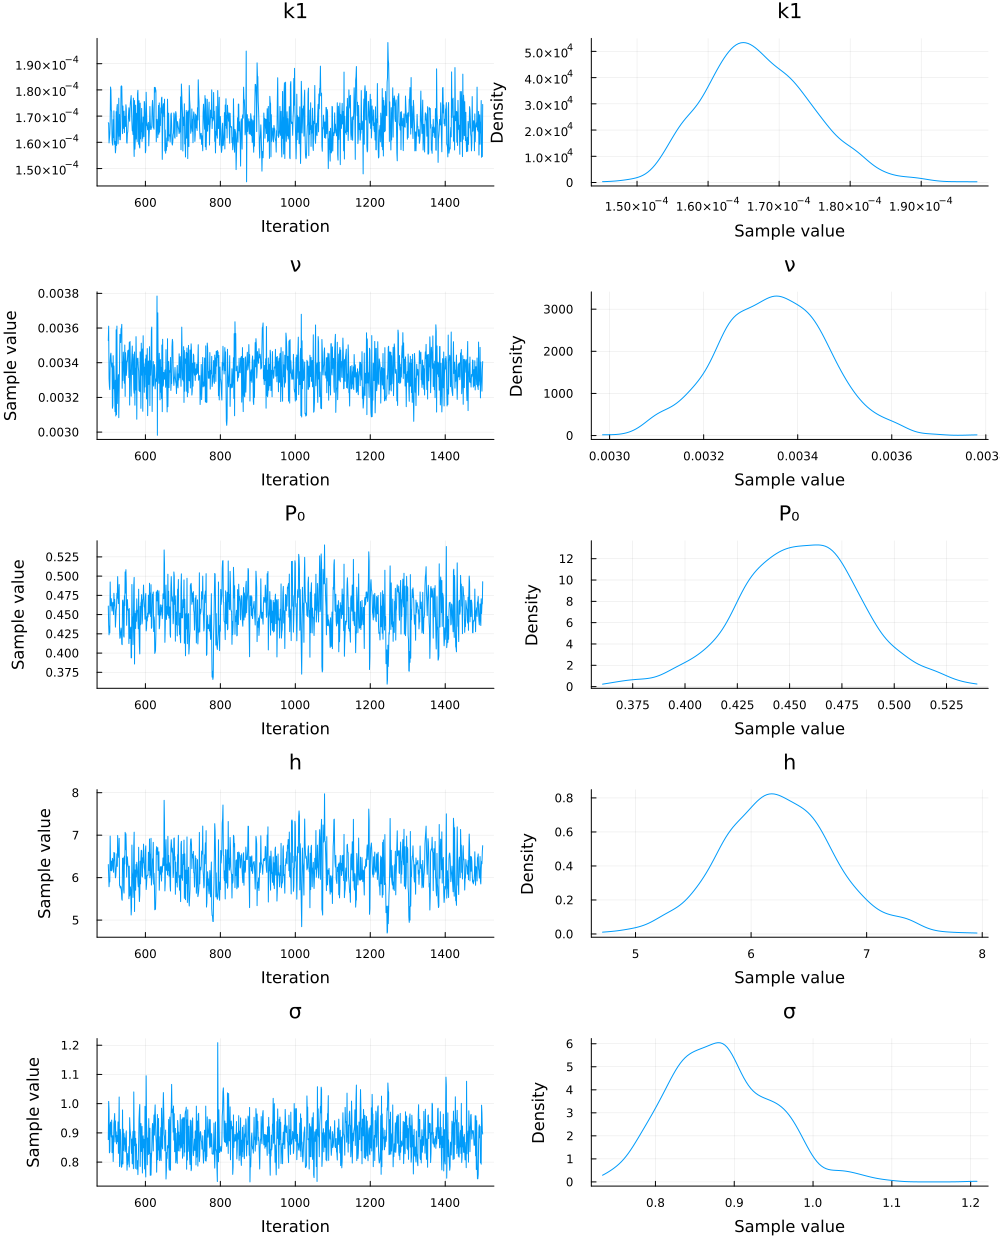

In [80]:
# Plot the chains and posteriors 
posteriors = plot(chain)

##### Posterior checks

We want to see what the uncertainty in our posterior model predicitons looks like in the space of our ODE model solutions. We can sample the ODE model predictions by solving our system of differential equations over the posteriors of the parameters (above) and we can estimate a pointwise 95% credible interval (confidence interval). 


In [81]:
# Function for making nice ribbon Plots given a chain of samples and prediction function
function estimate_credible_interval(chain, pred_func)
    # Get posterior MEAN model prediction to plot (at the mean posterior estimates of the parameters)
    param_predictions = [Turing.mean(chain[:k1]), Turing.mean(chain[:ν]), Turing.mean(chain[:P₀]), Turing.mean(chain[:h])]
    post_prediction = solve(prob, Tsit5(); p=param_predictions, saveat=1000)  
    
    # Collect solutions over samples posterior parameter values
    model_predictions = Any[]
    for p in eachrow(Array(posterior_samples))
        sol = pred_func(p)
        push!(model_predictions, sol)
    end
    
    pred_mRNA = hcat([model_predictions[i][1,:] for i in 1:length(model_predictions)]...)
    pred_proteins = hcat([model_predictions[i][2,:] + model_predictions[i][3,:] for i in 1:length(model_predictions)]...)

    mean_mRNA = mean(pred_mRNA, dims=1)'
    mean_proteins = mean(pred_proteins, dims=1)'

    # Compute 95% confidence intervals for the posterior predictions 
    lo_mRNA = mapslices(x->quantile(x,0.025), pred_mRNA, dims=1)'
    hi_mRNA = mapslices(x->quantile(x,0.975), pred_mRNA, dims=1)'
    lo_proteins = mapslices(x->quantile(x,0.025), pred_proteins, dims=1)'
    hi_proteins = mapslices(x->quantile(x,0.975), pred_proteins, dims=1)'

    # Plot simulation and noisy synthetic measurement data
    p1 = plot(post_prediction.t, post_prediction[1,:], legend=false, ribbon=(mean_mRNA-lo_mRNA,hi_mRNA-mean_mRNA), color=:pink, alpha = 0.5, xlabel="Time (s)", ylabel="Hes1 mRNA [conc.]", grid=false, framestyle=:box, linewidth=3, linecolor=:magenta, label="Posterior model")
    p2 = plot(post_prediction.t, post_prediction[2,:] .+ post_prediction[3,:], legend=false, ribbon=(mean_proteins-lo_proteins,hi_proteins-mean_proteins), color=:lightgreen, alpha = 0.5, xlabel="Time (s)", ylabel="Hes1 Proteins [conc.]", grid=false, framestyle=:box, linewidth=3, linecolor=:green, label="Posterior model")
    plot!(p1, nominal_res.t, nominal_res[1,:],linecolor=:grey, linewidth=3, label="Nominal Model", linestyle=:dash)
    plot!(p2, nominal_res.t, nominal_res[2,:] .+ nominal_res[3,:], linecolor=:grey, linewidth=3, label="Nominal Model", linestyle=:dash)
    
    scatter!(p1, data_res.t, synthetic_data[1,:]; color=:magenta, label="Data")
    scatter!(p2, data_res.t, synthetic_data[2,:] .+ synthetic_data[3,:]; color=:green, label="Data")

    plot(p1, p2, layout = l, legend=true)
end


estimate_credible_interval (generic function with 1 method)

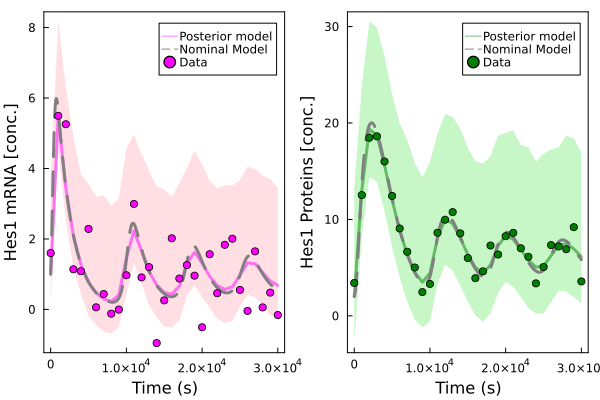

In [82]:
function solve_model(p)
    sol = solve(prob, Tsit5(); p=p, saveat=1000)
    return sol
end

# Sample the posterior distribution over model predictions
posterior_samples = Turing.sample(chain[[:k1, :ν, :P₀, :h]], 1000; replace=false)
estimate_credible_interval(posterior_samples, solve_model)


##### Posterior predictive distribution

Above, we plotted the 95% CI for the predictions made by our inferred posterior prediction. Here, we actuallt do not expect the 95% interval to contain 95% of the data, because we are ignoring part of the original statistical model: the stochastic random error model (i.e., the measurement noise). So we haven't really quantified the uncertainty in what we actually *observe*. For that, we will need more unseen observations. 

Let's assume data we've used in inference so far is $y$, and new unobserved data is $y'$.

What we want to use is the **posterior predictive distribution**, defined as:

$$p(y'|y) = \int p(y'|\theta) p(\theta|y)\,d\theta$$

The first factor in the integrand ($p(y'|\theta)$) is the likelihood of new data, conditional on the (unknown) deterministic model parameters. The second factor ($p(\theta|y)$) is the parameter posterior. We marginalize out the parameter uncertainty ($\theta$) to get the distribution of *new* data ($y'$), conditional on (fitting to) the observed data ($y$).

To compute this in a sample-wise fashion (because, in general, integrals are hard and Monte Carlo estimation is not), we draw a sample from the parameter posterior (our Markov chain), then conditional on the those parameters, sample from the likelihood by evaluating our ODE model at those parameters and adding a random draw of *iid* Gaussian noise from our statistical model. The 95% interval here should enclose 95% of the data points.

In [83]:
# Let's just define a function to make this noisy posterior evaluation for us
function sample_posterior_predictive(θ)
    model = solve(prob, Tsit5(); p=θ, saveat=1000)
    noise = σ*randn(length(model.t))
    pred = hcat(model[1,:] .+ noise, model[2,:] .+ noise, model[3,:] .+ noise)'
    return pred
end

sample_posterior_predictive (generic function with 1 method)

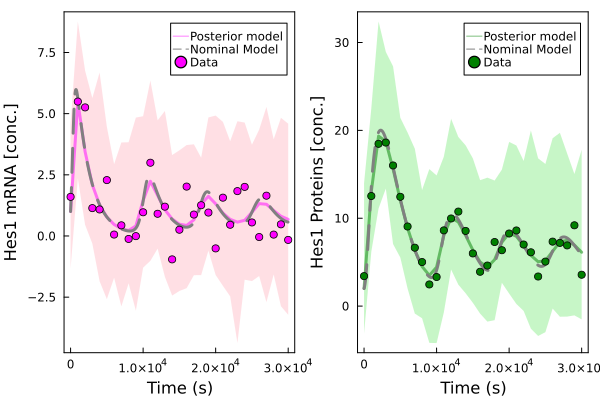

In [84]:
# Add posterior predictive and compare to posterior model predictions, ideally 95% of predictions will encompass data...
σ = 1.5 # The sigma from our statistical model 
estimate_credible_interval(posterior_samples, sample_posterior_predictive)


##### Parameter Correlation

We can look at correlations between the input parameters...this is related to sensitivity analysis, which we will go over in the next section. 

In the bottom left plots, we have scatter plots of the points samples in the MCMC chain. The diagonal plots are 1D histograms for the distributions of each parameter's posterior, and the right corner plots are 2D histograms. 

The marker color in the scatter plots reveals the degree of correlation. 
Here, positive correlations are blue, neutral are yellow and negative are red. In the 2d-histograms, the color gradient shows the frequency of points in that bin, where lighter colors are higher frequency. 

From these plots we learn that these is a large degree of positive correlation between the $h$ and $P_0$ parameters in our model, as well as a very slight positive correlation between $P_0$ and $k_1$.

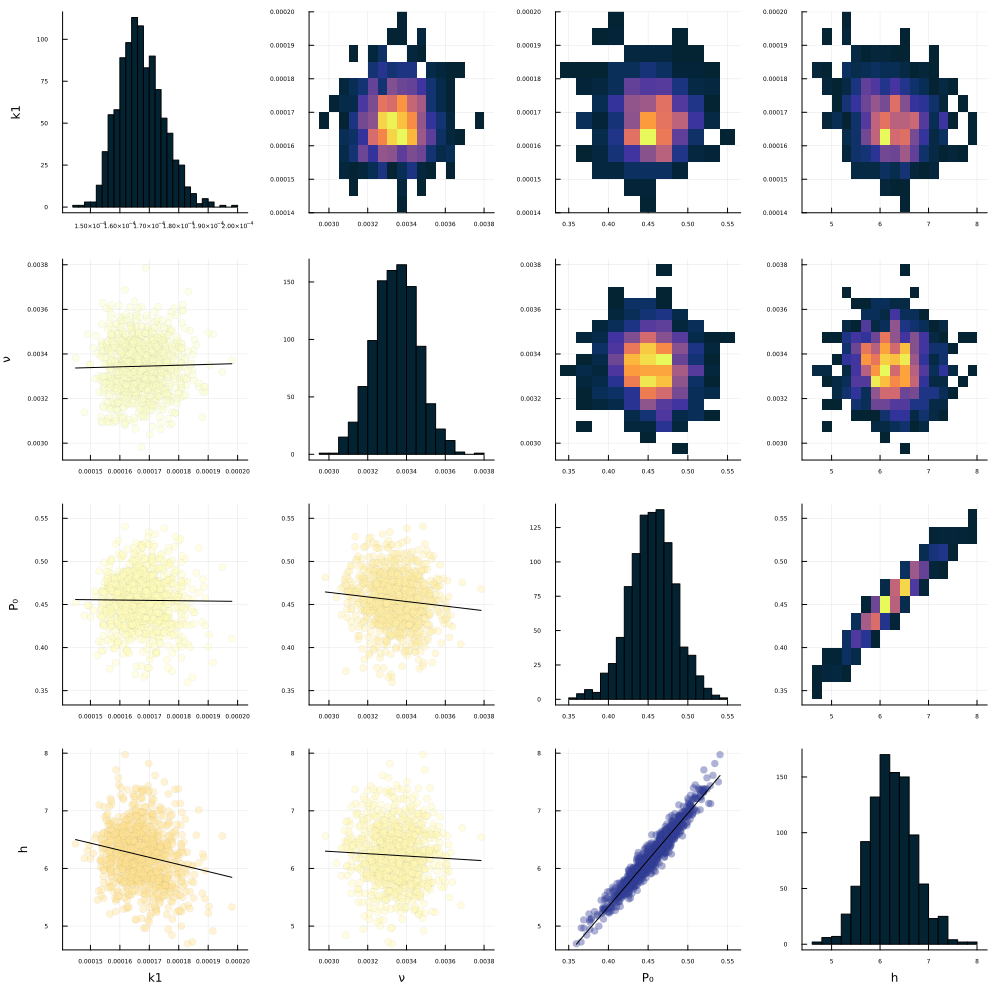

In [85]:
corrplot(Array(chain[[:k1, :ν, :P₀, :h]]), label=["k1", "ν", "P₀", "h"], tickfontsize=4, guidefontsize=8, formatter=:plain, size=(1000,1000), fc=:thermal)

#### Emulator Workflow

Sometimes, our models are easy to run in an ensemble of maybe hundreds of samples. But for very large input spaces or more complex models, we may need to run many order of magnitude more simulations to get good posterior estimations. HMC methods are effective but suffer from slow-downs as problem sizes increase. 

This is where (statistical) emulators become useful. Not only can we get a faster to run surrogate of our original model, but it will also estimate its own uncertainty in the predictions it makes! 

We have the ability to generate large quantites of simulation data from our computer models. We can do this by sampling from our prior distributions for parameter inputs and running many "forward runs" of our model to collect output data. This can be used to train an emulator of our simulation -- a data-driven model of our complex physical model which is orders of magnitude quicker to solve/evaluate. We can then use this emulator in our Bayesian workflow above in place of the system of ODEs. 

##### Step 1: Priors 

The first step of prior solicitation is easy for us here -- we'll just use what we assumed before. But in general this can be an interative process working with domain experts to create reasonable/meaningful distributions.

In [86]:
# Let's assume we have the same priors as before:
means = [1.66e-4, 3.33e-3, 0.5, 7.0]
stds = [0.00125, 0.00125, 0.25, 2.75]

# Make distributions
d = truncated.(Normal.(means, stds), lower=1e-8)

4-element Vector{Truncated{Normal{Float64}, Continuous, Float64}}:
 Truncated(Normal{Float64}(μ=0.000166, σ=0.00125); lower=1.0e-8)
 Truncated(Normal{Float64}(μ=0.00333, σ=0.00125); lower=1.0e-8)
 Truncated(Normal{Float64}(μ=0.5, σ=0.25); lower=1.0e-8)
 Truncated(Normal{Float64}(μ=7.0, σ=2.75); lower=1.0e-8)

##### Step 2: Ensemble Design 

Next, we need to consider what our sampling approach is going to be. Because we are generating our own training data, we want to be sure we are sampling the parameter space efficiently. As is the old adage in ML, garbage in, garbage out. If we don't have a good data set that represents the input and output of the model, we will end up with a poor emulator. 

For high-dimensional parameter spaces with large ranges of attainable values, a simple grid discritization would scale poorly and lead to lots of parameter value repetition (the so-called "collapsing property of grids"). More sophisticated ensemble design is required! And like a lot of things in UQ, this requires some finess and iteration because its a bit of an art with "rules of thumb" here and there.

A common approach for sampling is the standard random Monte-Carlo approach, but the efficiency of the Monte-Carlo method can be improved using other sampling techniques. In the literature, there are many sampling techniques, such as:

* Pesudo-random Monte-Carlo sampling

* Quasi-random Monte-Carlo sampling

* Latin hyper-cube sampling

* Importance sampling

(As mentioned in the slides, you can also do a 50/50 approach, sampling from some uniform space-filling method and also the expert priors.)

Sobol sampling is one such approach that falls into the Quasi-random Monte-Carlo designation. Sobol sampling aims to distribute points as uniformly as possible in each dimension. Added benefit is that these ensembles can be added to easily after they have been created. And Sobol sequences have a nice implementation in Julia, so let's use it!


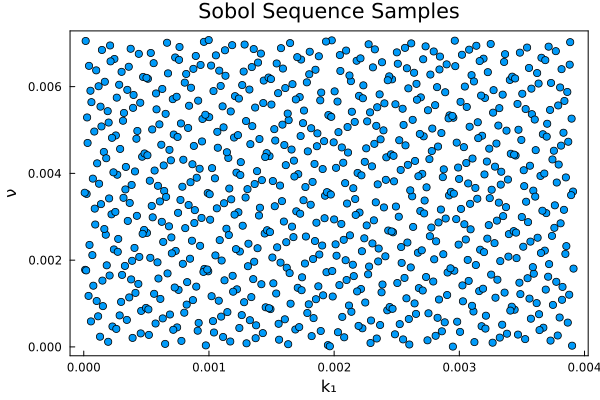

In [87]:
# Using our prior information on σ, we will sample from 0 to +3σ around the means for each parameter_ranges
lb = [0, 0, 0, 0]
ub = means .+ 3*stds
N_data = 800

s = SobolSeq(lb, ub)
ensemble_pnts = reduce(hcat, next!(s) for i = 1:N_data)'
scatter(ensemble_pnts[:,1], ensemble_pnts[:,2], xlabel="k₁", ylabel="ν", title="Sobol Sequence Samples", legend=false, grid=false, framestyle=:box)


Here we will generate our training data vectors based on the Sobol sequence defined above



In [88]:
X_data = zeros(N_data, 4)
Y_data = zeros(N_data, length(nominal_res.t))

for i in 1:N_data
    X_data[i,:] = ensemble_pnts[i, :]
    result = solve(prob, Tsit5(); p=ensemble_pnts[i, :], saveat=10)
    Y_data[i,:] = result[1,:]
end


##### Step 3: Dimensionality Reduction

We want to train a Gaussian Process emulator for our ODE system, perhaps because the ODE integrator is too slow for the scale of studies we wish to do with the model. 

GPs have pros (few hyperparameters to fit, built-in Bayesian uncertainties) and cons (not scalable to large data sets or high-dimensional data). The second "con" we can work around with some dimensionality reduction techniques. 

Next, we can consider doing dimensionality reduction in our *inputs*. For example, maybe we will only need samples for a single parameter if the model isn't sensitive the the rest! 

For this example, we only have 4 inputs. However, we can still do a sensitivity analysis to determine which parameters our model is most sensitive to, and thus decide which parameters are most key to do UQ for.

##### Sensitivity Analysis: Sobol Method

For sensativity analysis, you can do a "one-at-a-time" parameter sweep fairly easily, wherein you just sample across the range of a parameter and solve the model while holding all other parameters fixed. This is easy, but doesn't capture any "global" information about correlations between groups of parameters. For that, we can use a global sensitivity analysis method called the Sobol method. 

Generally, the Sobol method decomposes the variance in the model output into contributions from the variances in model input(s). These can be computed for single parameters, pairs of parameters, threes, and so on. The total Sobol index considers all contributions to model output variance from a single parameter. 



 32.977817 seconds (96.05 M allocations: 8.384 GiB, 4.37% gc time, 3.12% compilation time)


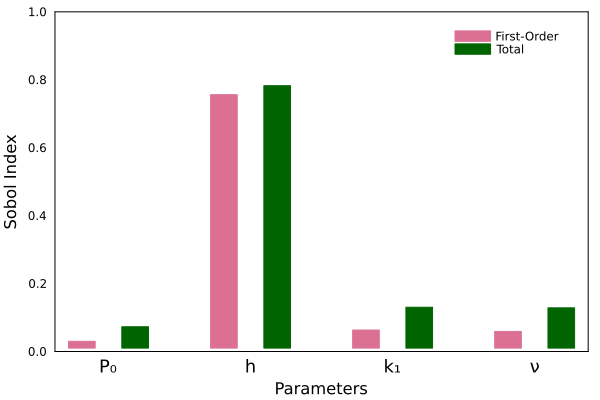

In [89]:
# Do a global sensitivity analysis on inputs based on peak mRNA concentration

# Define a QOI function
peak_mRNA_concentration(sol) = maximum(sol[1,:])
peak_mRNA_concentration(prob, p) = peak_mRNA_concentration(solve(remake(prob; p=p); saveat=1000))

sampler = QuasiMonteCarlo.SobolSample()
A,B = QuasiMonteCarlo.generate_design_matrices(100000, lb, ub, sampler, 2)
@time sobol_result = GlobalSensitivity.gsa(p -> peak_mRNA_concentration(prob, p), GlobalSensitivity.Sobol(order=[0,1]), A, B)
# Plot a bar graph of the first and total Sobol indices
fillrange = 0.01

z = collect(zip(sobol_result.S1, sobol_result.ST))
mat = [tup[k] for tup in z, k in 1:2]

ctg = repeat(["First-Order", "Total"], inner = 4)
nam = repeat(["k₁", "ν", "P₀", "h"], outer = 2)

plt = groupedbar(nam, mat, group = ctg, spacing=0.5, xlabel = "Parameters", ylabel = "Sobol Index",
        title = "", linecolor = [:palevioletred :darkgreen], framestyle = :box, ylim=(0,1), 
        xtickfontsize=12, bar_width=0.75, widen=false, fillrange = fillrange,
        grid=false, tick_direction=:none,c = [:palevioletred :darkgreen],legend_background_color=:white, legend_foreground_color=:white)
plot(plt)



Not too surprisingly (based on the result we've already seen in the HMC) the model QOI of maximum mRNA concentration is very sensitive the the $h$ parameter. Moving forward, for the purposes of building our emulator, lets only consider $h$ as an uncertain parameter, because the Sobol analysis tells us most of the uncertainty in the QOI is attributed to the uncertainty in this one parameter. 

##### Principal Component Analysis

In the case where we have many outputs to our ODE model, we may want to reduce the dimensionality of the *outputs* as well. PCA is a statistical dimensionality reduction technique for transforming data to a lower-dimensional coordinate system (described by each principal component) which describe most of the variance in the data. 

For this example, we will do PCA on the mRNA time series data, since it is related to our Quantity of Interest (QOI) or peak mRNA concentration. We could also fit to this directly, but this is an example of how to get emulation of a time series, afterall. 

If you wanted to do a "value of information" study in the context of optimal experimental design over many candidate experiments, you may consider doing PCA for every output of the model.

In [90]:
# Functions for doing PCA in Julia
project(pca_fit, Y) = projection(pca_fit)' * centralize(Y, pca_fit.mean) # [K x M] matrix; projections of the N observations onto leading K components, where Y is [D x M] array (set Y = X to project original data)
project(pca_fit, Y, J) = (projection(pca_fit)[:,1:J])' * centralize(Y, pca_fit.mean[1:J]) # [J x M] matrix; as above, but only using leading J <= K components

# reconstruction into original D-dimensional space
reconstruct_J(pca_fit, W, J) = decentralize(projection(pca_fit)[:,1:J] * W, pca_fit.mean[1:J]) # as above, but only using leading J <= K components to reconstruct, where W is [J x M]

# validating accuracy: cumulative proportion of variance explained
cumpropvar(pca_fit) = vec(cumsum(eigvals(pca_fit) ./ sum(eigvals(pca_fit))))

# validating accuracy: root mean square error of reconstruction
# RMSE for different numbers of PCs retained
rms_error(pca_fit, Y) = [rmsd(Y, reconstruct_J(pca_fit, project(pca_fit,Y,J), J)) for J = 1:size(projection(pca_fit),2)] # compute RMSE for all J <= K

rms_error (generic function with 1 method)

In [144]:
# Functions for defining inputs to GP Training
# Select mean and covariance function
mZero = MeanZero()                                  # Zero mean function
kern = Matern(5/2, zeros(4), 0.0) #+ SE(0.0, 0.0)  
                                                    


Type: Poly{Float64}, Params: [0.0, 0.0]

In [145]:
# Fit our GP and validate
N_folds = 2
idx_cross_validation = Array(ScikitLearn.CrossValidation.KFold(N_data, n_folds=N_folds))
gps_in_pc_space = Any[]
for i = 1:1
    # Partition train and test data
    indices_train = idx_cross_validation[i][1]
    indices_test = idx_cross_validation[i][2]

    # Parameter data and standardize
    Param_train = hcat([X_data[j,:] for j in indices_train]...)
    Param_test = hcat([X_data[j,:] for j in indices_test]...)

    # Time series data and standardize
    Y_train = hcat([Y_data[j,:] for j in indices_train]...)
    Y_test = hcat([Y_data[j,:] for j in indices_test]...)

    # perform PCA on time series data, retaining first K PCs
    pca_fit = fit(PCA, Y_train; maxoutdim=5) 

    # Transform train and test time series data
    Zt = project(pca_fit, Y_train)
    Zp = project(pca_fit, Y_test)

    # Fit GP model on transformed training data
    Zp_hat = zeros(size(Zp))
    for j = 1:size(pca_fit, 2)     
        gp = GP(Param_train, Zt[j, :], mZero, kern)
        optimize!(gp)
        μ, σ² = predict_y(gp, Param_test)
        Zp_hat[j, :] = μ
    end
    gps_in_pc_space = Zp_hat
    println(Zp_hat)
    
    # Revert PCA transformation on testing data 
    Xp_hat = reconstruct(pca_fit, Zp_hat)

    # Plot residuals between predicted mean and test data
    residual_plot = plot(xlabel="Time (s)", ylabel="Residual after Reconstruction")
    for j = 1:10:size(Y_test, 2)
        plot!(residual_plot, nominal_res.t, (Y_test[:, j] .- Xp_hat[:, j]), label="", legend=false)
    end
    display(residual_plot)
    savefig(residual_plot, "residuals.png")

    # Compare some individual predictions 
    for j = 1:1:10
        emulator_prediction_plot = plot(xlabel="Time (s)", ylabel="Hes1 mRNA [conc.]", legend=true)
        plot!(emulator_prediction_plot, nominal_res.t, Y_test[:, j], label="True")
        display(plot!(emulator_prediction_plot, nominal_res.t, Xp_hat[:, j], label="Predicted"))
        savefig(emulator_prediction_plot, "true_vs_reconstructed_$j.png")
    end
end

PosDefException: PosDefException: matrix is not positive definite; Cholesky factorization failed.

In [95]:
println(size(gps_in_pc_space))

(2, 400)


We can see that our emulator isn't really capturing the correct behavior of our ODE system. This could be happening for a number of reasons.

* The PCA is only predicting 2 PCs, which may be insufficient to capture the dynamics represented across the prior uncertainty space
* Using a GP makes some assumptions regarding your underlying model, which may not be satisfied! stationarity, smoothness...

 I leave it as an exercise to the reader to sleuth this out if I haven't figured this out before the tutorial...